# Análise de Dados Bancários: Identificação de Problemas, Análise Exploratória e Projeção de Crescimento

**História**: Nesta avaliação encaminhamos em anexo um arquivo compactado com dados em csv . A base de
dados apresenta informações fictícias sobre operações de clientes de uma instituição bancária. O
tempo previsto para execução desta atividade é de até 2h. Utilizando Python e Jupyter Notebook,
faça as seguintes tarefas:


**1. Faça uma análise inicial dos dados:** você encontrou algum problema? Como você trataria
estes problemas?


**2. Faça uma análise exploratória dos dados:** distribuições de variáveis, outliers, correlações,
etc.


**3. Faça uma projeção do crescimento da carteira para os próximos 2 anos em termos de
volume de operações e da carteira utilizando os métodos de ciência de dados que julgar
mais adequados para essa tarefa.**


**Autor**: João Felipe Teixeira Cortezi Goulart de Moura

# 0.0. Importações

In [ ]:
import math
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import datetime as dt

from math                        import floor
from datetime                    import datetime
from matplotlib                  import pyplot as plt
from sklearn.metrics             import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble            import RandomForestRegressor
from sklearn.linear_model        import LinearRegression
from sklearn.preprocessing       import LabelEncoder, MinMaxScaler
from sklearn.model_selection     import cross_val_score, TimeSeriesSplit
from sklearn.feature_selection   import SelectFromModel, SelectPercentile, f_regression

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
# Ignorar avisos
warnings.filterwarnings("ignore")

## 0.1 Funções

In [ ]:
def ml_error( model_name, y, yhat ):
    """ Calcula os erros do modelo recebido
    model_name: nome do modelo
             y: valores de vendas reais
          yhat: valores de vendas estimados pelo modelo """
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse  }, index=[0] )

## 0.1. Carregar Dados

In [ ]:
df = pd.read_csv("/Users/joaocortezi/Documents/Parana_banco/dados_operacoes.csv")

In [ ]:
# Substituir "Null" por NaN
df.replace("Null", np.nan, inplace=True)

In [ ]:
df.head(15)

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,telefone,cartao,email,ocupacao,empregador,operacao,valor_principal,parcelas,quantidade_parcelas,parcelas_pagas,quantidade_parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,682e8b505c30bb12052f9457516dc47e7eafc8ed,1760865030954,2019-09-13,1974-06-08,48,F,Conjunto Paulo Vi,Moreira,Rio de Janeiro,XXXXX-685,XXXXXXXXXXXXX2797,NaN,XXXXa51@mXXXXXXXXXXXX,Espeleologista,e53d5342e82e0ce6061bc3aaea1a986f24a73613,Prod,27810.69,100,100,20,20,1.46493,531.56,53156.0000
1,45ad9d444a276407df8b6f47c0fcc5b127dadaaa,6023030871505,2022-11-03,1988-07-23,34,F,Minas Caixa,da Mota de Azevedo,Amapá,XXXXX735,NaN,XXXXXXXXXX562960,XXXXXXXXXXXnda@tXXXXXXXXXXXX,Mágico,f715ffaf2c8294df43df3357c6a37f04b900fb06,Refin,9589.96,40,40,6,6,4.53587,523.82,20952.8000
2,81cec74ea2ca41535fee03daeb410ddbdf12906a,560263027614,2021-06-13,1975-08-17,NaN,NaN,Vila Mantiqueira,Rocha da Prata,Santa Catarina,XXXXX863,XXXXXXXXXXXXX1-3076,XXXXXXXXXX55,NaN,NaN,da9515ffa45dd12791be0941b91188e51fe1cc04,Prod,42963.20,100,100,10,10,1.44749,815.71,81571.0000
3,4e987d9178e2dcb07c2bf3878736233a676a0a87,1397061435926,2021-08-30,1982-08-17,40,F,Anchieta,da Mata,NaN,NaN,NaN,NaN,NaN,Conferente de carga e descarga,0c1741dc26339e6af3e4b6badcf984d383d1ca44,Port + Refin,2954.14,120,120,6,6,1.82904,60.96,7315.1997
4,595943ecdb32a24ccb6ef374b6d865f3b60d7130,3823566005671,2022-11-16,1985-07-14,37,F,Conjunto Floramar,Moreira de Goiás,Mato Grosso,XXXXX384,XXXXXXXXXXXXX7089,NaN,NaN,Treinador,f97b240dc24290c19e717d7a654747aa31722ad3,Prod,31186.17,100,100,10,10,3.28340,1066.11,106611.0000
5,5e45a621fbb7998f7588091f8b7d480d3b24b2fc,5444678845030,2020-11-02,1984-05-29,38,M,Vila Fumec,Campos,Roraima,NaN,XXXXXXXXXXXXX91 1070,XXXXXXXXXX12230,NaN,Cirurgião bucal,NaN,Port + Refin,41432.39,40,40,8,8,0.70787,1193.00,47720.0000
6,a31aba3a584cedd544a31cfe3af96a0dc06bad17,9023412229198,2019-11-22,1997-02-10,26,M,NaN,NaN,Pernambuco,XXXXX-022,XXXXXXXXXXXXX9-1921,XXXXXXXXXX13258,NaN,Produtor de audio visual,25474923a0bac6ed841e0b776b035c73c444da1f,Prod,16870.66,60,60,9,9,1.13080,388.80,23328.0000
7,b0798e02f03eb1ad4ef5a8cbbc69e2732a7052d0,4167168660296,2021-12-08,1997-10-18,25,F,Vila Da Ária,Araújo,Alagoas,XXXXX007,XXXXXXXXXXXXX4284,NaN,XXXXXXXXXXXXXara@aXXXXXXXXXXXX,Velejador,8e9e183c401487c93eb9c9127d15e0908208d252,Refin,2832.39,80,80,12,12,2.67154,86.12,6889.6000
8,1676c0f980840a4fb7d808fc831412e8cc0c1b29,7565583960651,2022-08-18,1984-06-17,38,M,Vila Tirol,Campos,Alagoas,XXXXX935,XXXXXXXXXXXXX42 5215,NaN,XXXXXXXXlyn@pXXXXXXXXXXXX,Soldado,ecfeed45ad3c07bc0533b71937ff3fb0be094a12,Prod,22710.72,40,40,10,10,3.64272,1087.15,43486.0000
9,3411c0726cfae279d32d3a6a1d1c8a8fc560ffd5,7872966313608,2019-12-04,1999-11-17,23,M,Nossa Senhora Do Rosário,Fogaça,Ceará,XXXXX304,XXXXXXXXXXXXX48 3612,NaN,XXXXXXXXcia@aXXXXXXXXXXXX,NaN,8032e14ec79691c862249d17e0050d7da49913b9,Prod,18878.32,40,40,0,0,0.99986,574.94,22997.6000


Refin: Quando a pessoa está em débito com a instituiação
Prod:
Port+Refin: portabilidade de débito

# 1.0. Descrição dos Dados

## 1.1. Dimensão dos Dados

In [ ]:
print ("Número de Linhas:{}" .format( df.shape[0]))
print ("Número de Colunas:{}" .format( df.shape[1]))

Número de Linhas:14895
Número de Colunas:24


## 1.2. Tipo dos Dados

In [ ]:
df.dtypes

id                            object
contrato                       int64
data_operacao                 object
nascimento                    object
idade                         object
genero                        object
bairro                        object
cidade                        object
estado                        object
cep                           object
telefone                      object
cartao                        object
email                         object
ocupacao                      object
empregador                    object
operacao                      object
valor_principal              float64
parcelas                       int64
quantidade_parcelas            int64
parcelas_pagas                 int64
quantidade_parcelas_pagas      int64
taxa_contrato                float64
valor_parcela                float64
valor_bruto                  float64
dtype: object

## 1.3.  Checar Dados Faltantes

In [ ]:
df.isna().sum()

id                              0
contrato                        0
data_operacao                   0
nascimento                      0
idade                        3005
genero                       1487
bairro                       2539
cidade                       2831
estado                       2234
cep                          3754
telefone                     4655
cartao                       5279
email                        4667
ocupacao                     2271
empregador                   3124
operacao                        0
valor_principal                 0
parcelas                        0
quantidade_parcelas             0
parcelas_pagas                  0
quantidade_parcelas_pagas       0
taxa_contrato                   0
valor_parcela                   0
valor_bruto                     0
dtype: int64

## 1.4. Preencher os Dados Faltantes

In [ ]:
#idade - Vamos calcular a idade baseado na data de nascimento e a data atual.
# Converter a coluna "nascimento" para o tipo "datetime"
df["nascimento"] = pd.to_datetime(df["nascimento"])

data_atual = datetime.now()
df["idade"] = (data_atual - df["nascimento"]).astype("<m8[Y]").apply(floor)

# cep - Substituir por XXXXX-XXX - substituido pois tem valores sensíveis
df["cep"].fillna("XXXXX-XXX", inplace=True)

# telefone - Substituir por XXXXX-XXXX
df["telefone"].fillna("XXXXX-XXXX", inplace=True)

# cartao - Substituir por XXXX.XXXX.XXXX.XXXX
df["cartao"].fillna("XXXX.XXXX.XXXX.XXXX", inplace=True)

# email - Substituir por xxx@xxxxx.com
df["email"].fillna("xxx@xxxxx.com", inplace=True)

# ocupacao - Vamos assumir que quem não tem ocupação cadastrada, seja autônomo
df["ocupacao"].fillna("autônomo", inplace=True)

# empregador - Vamos assumir que quem não tem empregador cadastrado, seja autônomo
df["empregador"].fillna("autônomo", inplace=True)

# As informações nas colunas genero, bairro, cidade, estado são importantes para "conhecer" o tipo de clientes
df.dropna(inplace=True)

#Tirar a coluna quantidade_parcelas_pagas pois tem a mesma informação da coluna parcelas_pagas
df.drop("quantidade_parcelas_pagas", axis=1, inplace=True)

#Tirar a coluna quantidade_parcelas pois tem a mesma informação da coluna parcelas
df.drop("quantidade_parcelas", axis=1, inplace=True)

In [ ]:
df.isna().sum()

id                 0
contrato           0
data_operacao      0
nascimento         0
idade              0
genero             0
bairro             0
cidade             0
estado             0
cep                0
telefone           0
cartao             0
email              0
ocupacao           0
empregador         0
operacao           0
valor_principal    0
parcelas           0
parcelas_pagas     0
taxa_contrato      0
valor_parcela      0
valor_bruto        0
dtype: int64

## 1.5. Estatística Descritiva

In [ ]:
num_at = df.select_dtypes(include=["int64", "float64"]).drop(columns=["contrato"])
cat_at = df[["genero", "estado", "ocupacao", "operacao"]]

### 1.5.1. Atributos Numéricos

In [ ]:
# Definir formato de exibição dos números
pd.options.display.float_format = "{:.2f}".format

# tendencia central - media, mediana
tc1 = pd.DataFrame(num_at.apply(np.mean).round(2)).T
tc2 = pd.DataFrame(num_at.apply(np.median).round(2)).T

# dispersão - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_at.apply(np.std).round(2)).T
d2 = pd.DataFrame(num_at.apply(np.min).round(2)).T
d3 = pd.DataFrame(num_at.apply(np.max).round(2)).T
d4 = pd.DataFrame(num_at.apply(lambda x: x.max() - x.min()).round(2)).T
d5 = pd.DataFrame(num_at.apply(lambda x: x.skew()).round(2)).T
d6 = pd.DataFrame(num_at.apply(lambda x: x.kurtosis()).round(2)).T

# concatenando
num_metrics = pd.concat([d2, d3, d4, tc1, tc2, d1, d5, d6]).T.reset_index()
num_metrics.columns = ["atributos", "min", "max", "range", "media", "mediana", "std", "skew", "kurtosis"]
num_metrics

,atributos,min,max,range,media,mediana,std,skew,kurtosis
0,idade,21.00,53.00,32.00,36.79,37.00,9.30,0.05,-1.21
1,valor_principal,207.09,49995.02,49787.93,23073.99,19940.76,13439.01,0.29,-1.03
2,parcelas,40.00,120.00,80.00,68.31,60.00,27.18,0.55,-0.97
3,parcelas_pagas,0.00,108.00,108.00,15.77,9.00,17.50,2.59,7.44
4,taxa_contrato,0.35,6.46,6.11,2.14,1.80,1.36,0.79,-0.28
5,valor_parcela,5.51,2788.25,2782.74,723.15,596.98,519.29,1.06,0.87
6,valor_bruto,308.00,328663.22,328355.22,47281.37,37822.20,39999.98,2.22,7.56


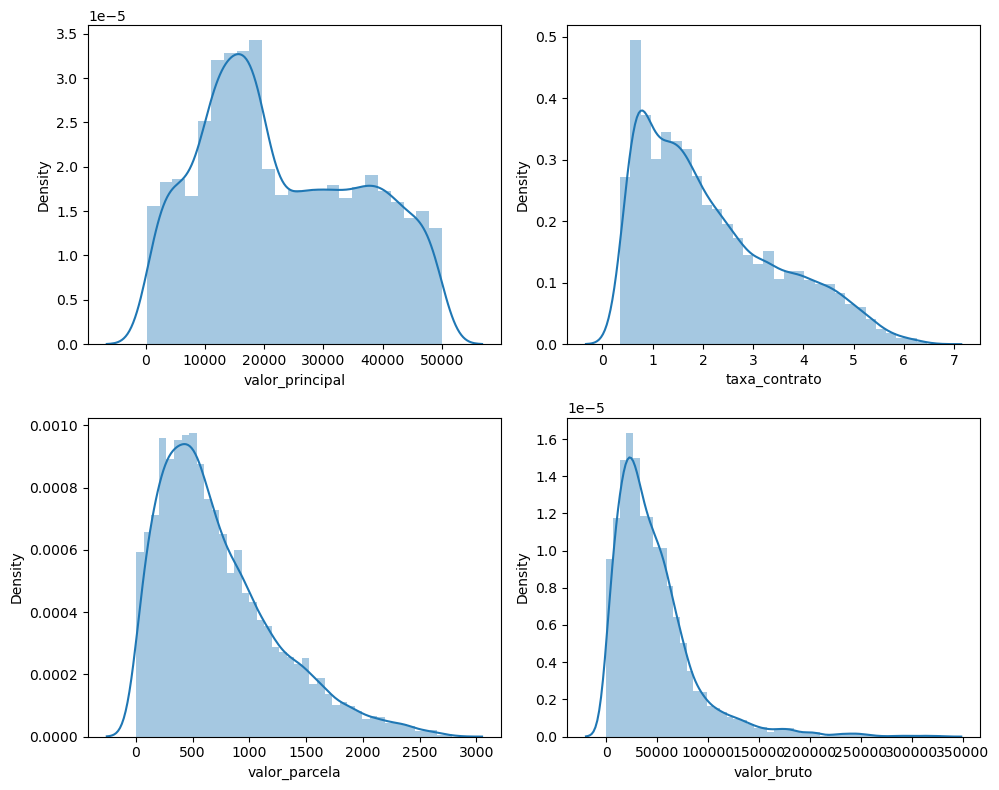

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.distplot(df["valor_principal"])

plt.subplot(2, 2, 2)
sns.distplot(df["taxa_contrato"])

plt.subplot(2, 2, 3)
sns.distplot(df["valor_parcela"])

plt.subplot(2, 2, 4)
sns.distplot(df["valor_bruto"])

plt.tight_layout()
plt.show()

### 1.5.2. Atributos Categóricos

In [ ]:
cat_at.apply (lambda x: x.unique().shape[0])

genero        2
estado       27
ocupacao    743
operacao      3
dtype: int64

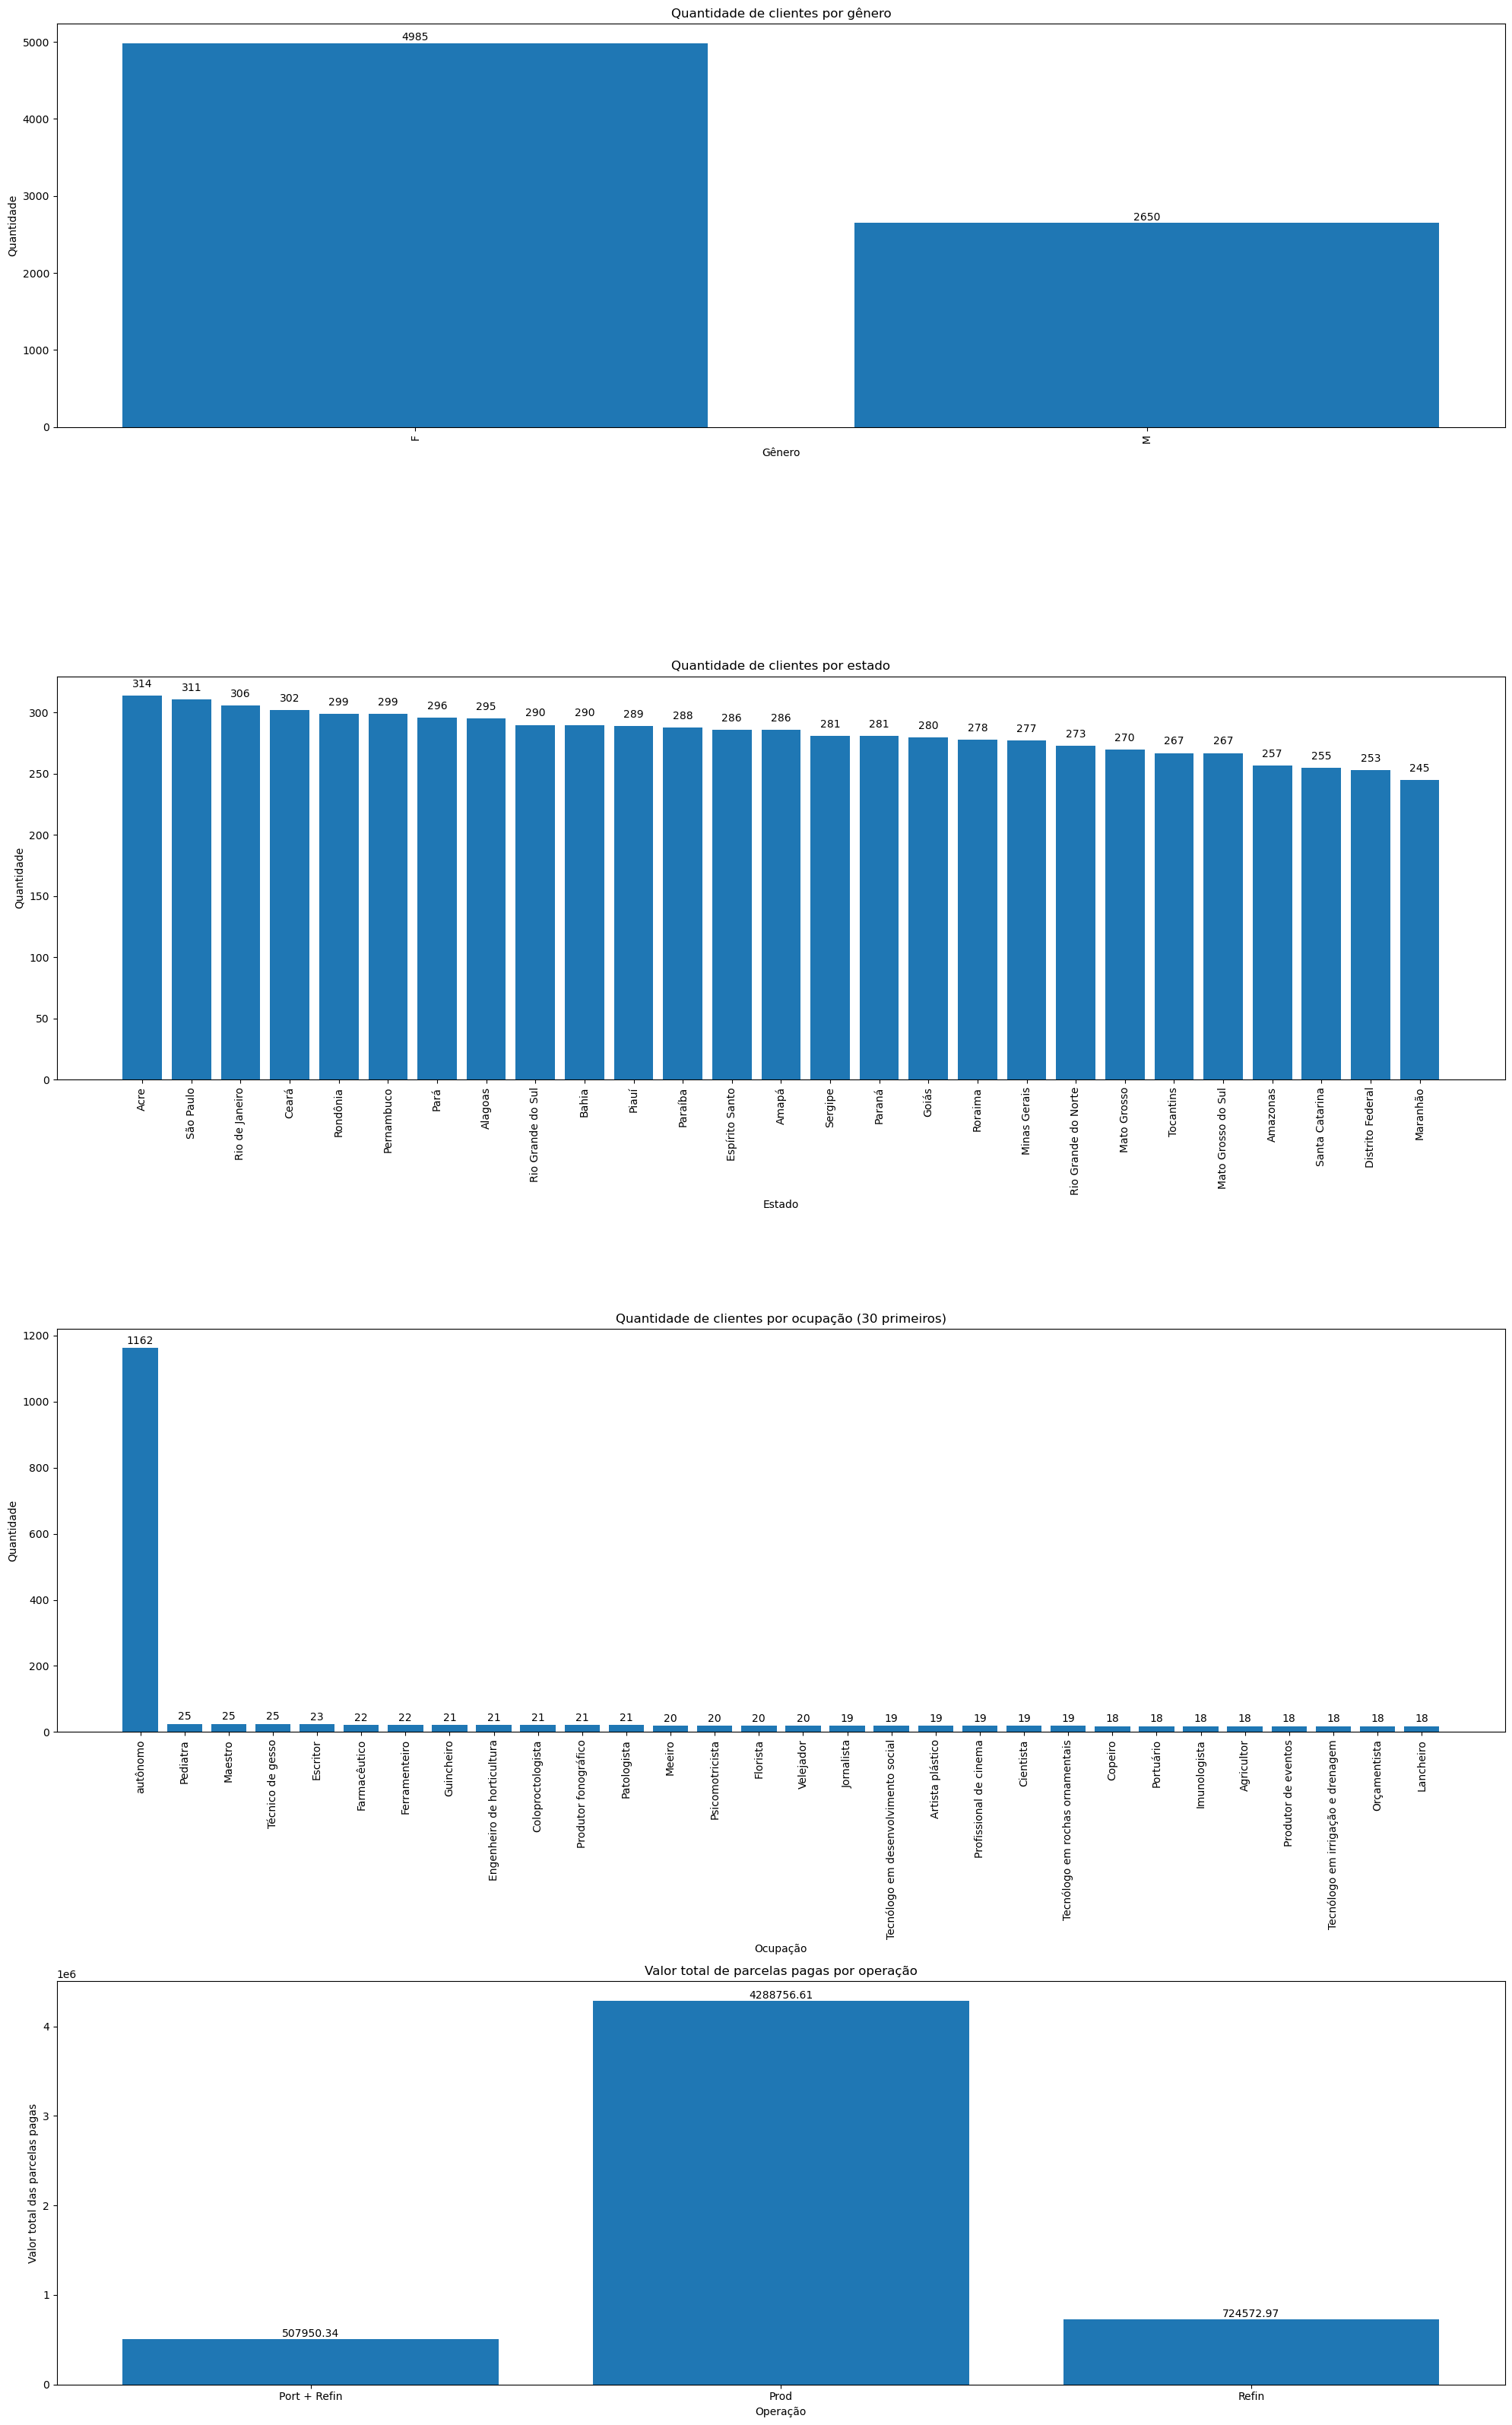

In [ ]:
# Configuração dos subplots
fig, axs = plt.subplots(4, 1, figsize=(20, 32))

# Quantidade de clientes por gênero
contagem_genero = df["genero"].value_counts()
axs[0].bar(contagem_genero.index, contagem_genero.values)
axs[0].set_title("Quantidade de clientes por gênero")
axs[0].set_xlabel("Gênero")
axs[0].set_ylabel("Quantidade")
axs[0].tick_params(axis="x", rotation=90)

# Adicionar rótulos aos dados do gráfico de quantidade de clientes por gênero
for i, v in enumerate(contagem_genero.values):
    axs[0].text(i, v + 5, str(v), ha="center", va="bottom")

# Quantidade de clientes por estado
contagem_estado = df["estado"].value_counts()
axs[1].bar(contagem_estado.index, contagem_estado.values)
axs[1].set_title("Quantidade de clientes por estado")
axs[1].set_xlabel("Estado")
axs[1].set_ylabel("Quantidade")
axs[1].tick_params(axis="x", rotation=90)

# Adicionar rótulos aos dados do gráfico de quantidade de clientes por estado
for i, v in enumerate(contagem_estado.values):
    axs[1].text(i, v + 5, str(v), ha="center", va="bottom")

# Quantidade de clientes por ocupação (apenas os 30 primeiros)
contagem_ocupacao = df["ocupacao"].value_counts().head(30)
axs[2].bar(contagem_ocupacao.index, contagem_ocupacao.values)
axs[2].set_title("Quantidade de clientes por ocupação (30 primeiros)")
axs[2].set_xlabel("Ocupação")
axs[2].set_ylabel("Quantidade")
axs[2].tick_params(axis="x", rotation=90)

# Adicionar rótulos aos dados do gráfico de quantidade de clientes por ocupação
for i, v in enumerate(contagem_ocupacao.values):
    axs[2].text(i, v + 5, str(v), ha="center", va="bottom")

# Valor total de parcelas pagas por operação
valor_total_parcelas_pagas = df.groupby("operacao")["valor_parcela"].sum()
axs[3].bar(valor_total_parcelas_pagas.index, valor_total_parcelas_pagas.values)
axs[3].set_title("Valor total de parcelas pagas por operação")
axs[3].set_xlabel("Operação")
axs[3].set_ylabel("Valor total das parcelas pagas")

# Adicionar rótulos aos dados do gráfico de valor total de parcelas pagas por operação
for i, v in enumerate(valor_total_parcelas_pagas.values):
    axs[3].text(i, v + 5, str(v), ha="center", va="bottom")

# Ajustar espaçamento entre subplots
plt.tight_layout()

# Exibir os gráficos
plt.show()

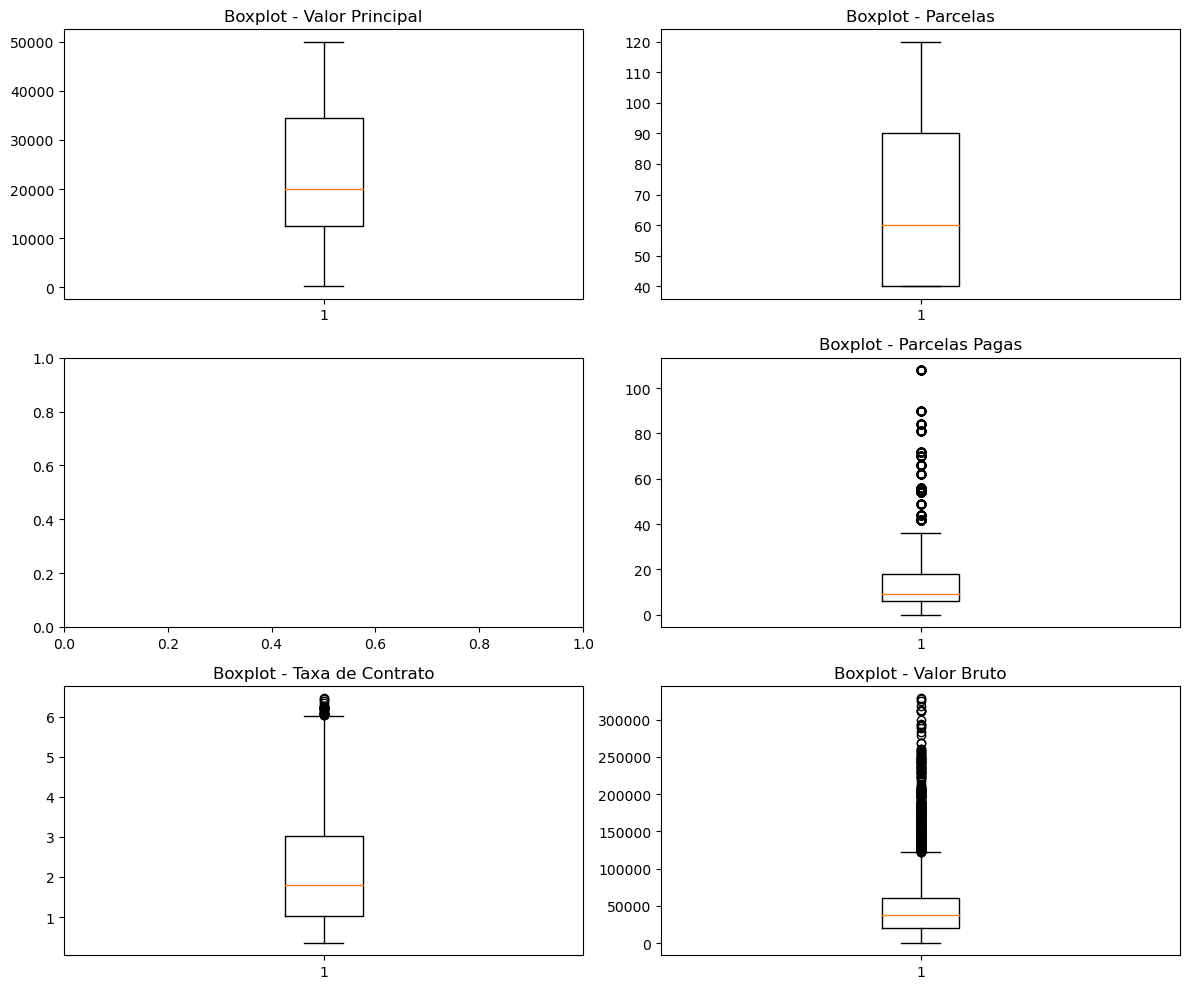

In [ ]:
# Configuração dos subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Boxplot do valor_principal
axs[0, 0].boxplot(df["valor_principal"])
axs[0, 0].set_title("Boxplot - Valor Principal")

# Boxplot do parcelas
axs[0, 1].boxplot(df["parcelas"])
axs[0, 1].set_title("Boxplot - Parcelas")

# Boxplot de parcelas_pagas
axs[1, 1].boxplot(df["parcelas_pagas"])
axs[1, 1].set_title("Boxplot - Parcelas Pagas")

# Boxplot de taxa_contrato
axs[2, 0].boxplot(df["taxa_contrato"])
axs[2, 0].set_title("Boxplot - Taxa de Contrato")

# Boxplot de valor_bruto
axs[2, 1].boxplot(df["valor_bruto"])
axs[2, 1].set_title("Boxplot - Valor Bruto")

# Ajustar espaçamento entre subplots
plt.tight_layout()

# Exibir os boxplots
plt.show()

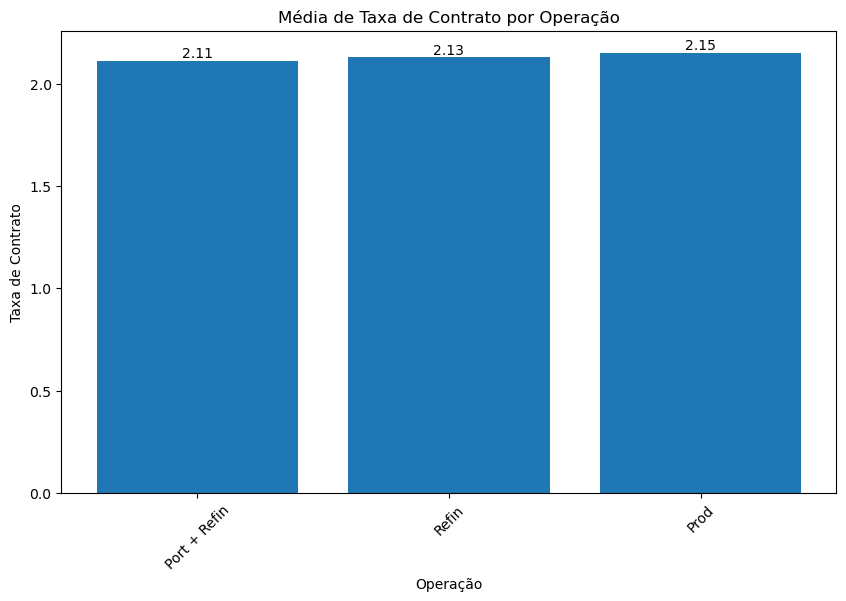

In [ ]:
import matplotlib.pyplot as plt

# Agrupar as taxas de contrato por operação e calcular a média
taxas_operacao = df.groupby("operacao")["taxa_contrato"].mean()

# Ordenar as operações pela taxa de contrato média em ordem crescente
taxas_operacao_sorted = taxas_operacao.sort_values()

# Configurar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(taxas_operacao_sorted.index, taxas_operacao_sorted.values)
plt.title("Média de Taxa de Contrato por Operação")
plt.xlabel("Operação")
plt.ylabel("Taxa de Contrato")

# Adicionar rótulos aos dados do gráfico
for i, v in enumerate(taxas_operacao_sorted.values):
    plt.text(i, v, "{:.2f}".format(v), ha="center", va="bottom")

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

In [ ]:
# Verificar se um mesmo ID tem mais de um contrato
tem_duplicatas = df.duplicated(subset="id", keep=False).any()

if tem_duplicatas:
    print("Existem IDs com mais de um contrato")
else:
    print("Não existem IDs com mais de um contrato")

Existem IDs com mais de um contrato


In [ ]:
# Criar uma tabela com os IDs e suas contagens de contratos
tabela_contratos = pd.DataFrame({"ID": df["id"].value_counts().index, "Quantidade de Contratos": df["id"].value_counts().values})

# Ordenar a tabela pela quantidade de contratos em ordem decrescente
tabela_contratos = tabela_contratos.sort_values(by="Quantidade de Contratos", ascending=False)

# Exibir a tabela
print(tabela_contratos)

                                            ID  Quantidade de Contratos
0     056adde9355103f12cd28336fd760f40afeecf7a                        6
2     2255b6fdbca8679bcaadd475f2c76ecff0649501                        6
3     76165b2747bee94ea4a4b9e3910d86eea265daa3                        6
4     0df2e7bf8c5b75b15fc400a11e6e52f96cb9f9ba                        6
5     d0f66d617da341dc62de13cf4467a6c6e12b0941                        6
...                                        ...                      ...
2685  500ba01d44fb84600aa120e5ca344bbc0ef4860e                        1
2684  d577c407cc9d94f5207dcdd7e1d9747496032b29                        1
2683  875aa4a1b065dc01bdfd4e8249caef852ec0eece                        1
2682  cf404f07aea0a34b729c0ea27795dfe0019974cb                        1
3823  682e8b505c30bb12052f9457516dc47e7eafc8ed                        1

[3824 rows x 2 columns]


# 2.0. Análise de Hipóteses

## 2.1. A taxa de contrato varia de acordo com a ocupação dos clientes.

**Correto:** A taxa varia de acorodo com a ocupação.

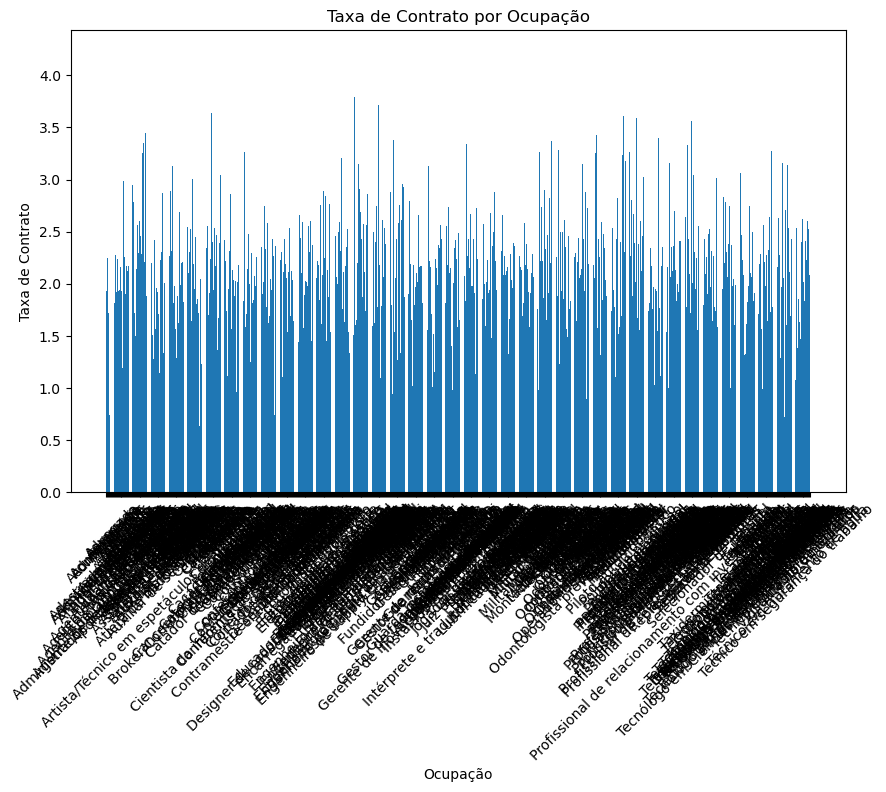

In [ ]:
# Calcular a média das taxas de contrato por ocupação
taxas_ocupacao = df.groupby("ocupacao")["taxa_contrato"].mean()

# Configurar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(taxas_ocupacao.index, taxas_ocupacao.values)
plt.title("Taxa de Contrato por Ocupação")
plt.xlabel("Ocupação")
plt.ylabel("Taxa de Contrato")

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

In [ ]:
print(df.groupby("ocupacao")["taxa_contrato"].mean().reset_index().sort_values(by="taxa_contrato", ascending=False))

                                ocupacao  taxa_contrato
433                      Marcador de luz           4.22
162            Conferente de recebimento           4.06
490                          Oceanógrafo           3.87
262  Engenheiro de segurança do trabalho           3.80
606                           Radialista           3.78
..                                   ...            ...
8                               Aeromoça           0.80
3                          Administrador           0.74
177                           Coreógrafo           0.74
715                Técnico em radiologia           0.72
98                             Bóia-fria           0.64

[743 rows x 2 columns]


## 2.2. <s> A taxa de contrato tem relação com a idade dos clientes.</s>

**Errado:** A idade não influência em quase nada na taxa de contrato. Provavelmente essa pouca difença está relacionada à quantidade de pessoas em cada faixa etária.

posx and posy should be finite values
posx and posy should be finite values


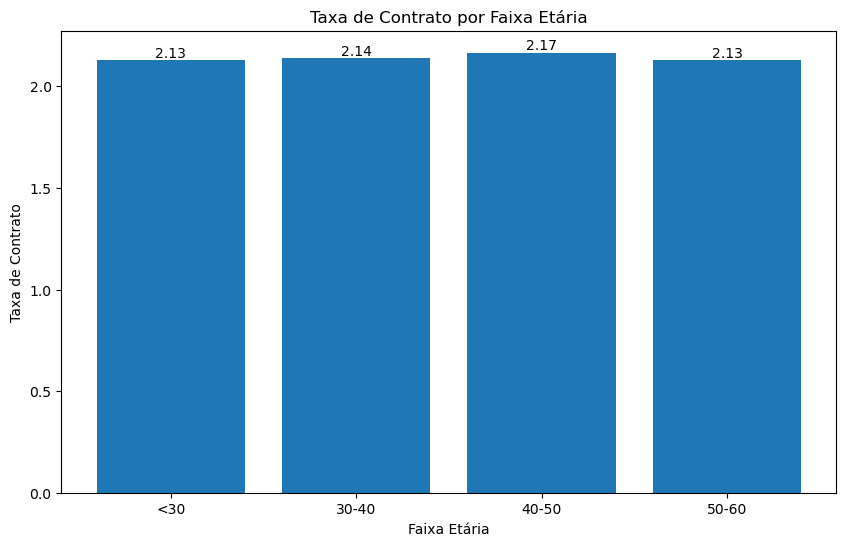

In [ ]:
# Dividir os clientes em faixas etárias
bins = [0, 30, 40, 50, 60, 100]  # Defina as faixas etárias desejadas
labels = ["<30", "30-40", "40-50", "50-60", "60+"]  # Rótulos para cada faixa etária
df["faixa_etaria"] = pd.cut(df["idade"], bins=bins, labels=labels, right=False)

# Calcular a média das taxas de contrato por faixa etária
taxas_faixa_etaria = df.groupby("faixa_etaria")["taxa_contrato"].mean()

# Configurar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(taxas_faixa_etaria.index, taxas_faixa_etaria.values)
plt.title("Taxa de Contrato por Faixa Etária")
plt.xlabel("Faixa Etária")
plt.ylabel("Taxa de Contrato")

# Adicionar rótulos aos dados do gráfico
for i, v in enumerate(taxas_faixa_etaria.values):
    plt.text(i, v, "{:.2f}".format(v), ha="center", va="bottom")

# Exibir o gráfico
plt.show()

## 2.3. A taxa de contrato varia de acordo com a cidade dos clientes.

**Correto:** A taxa de algumas cidade é bem menor do que outras.

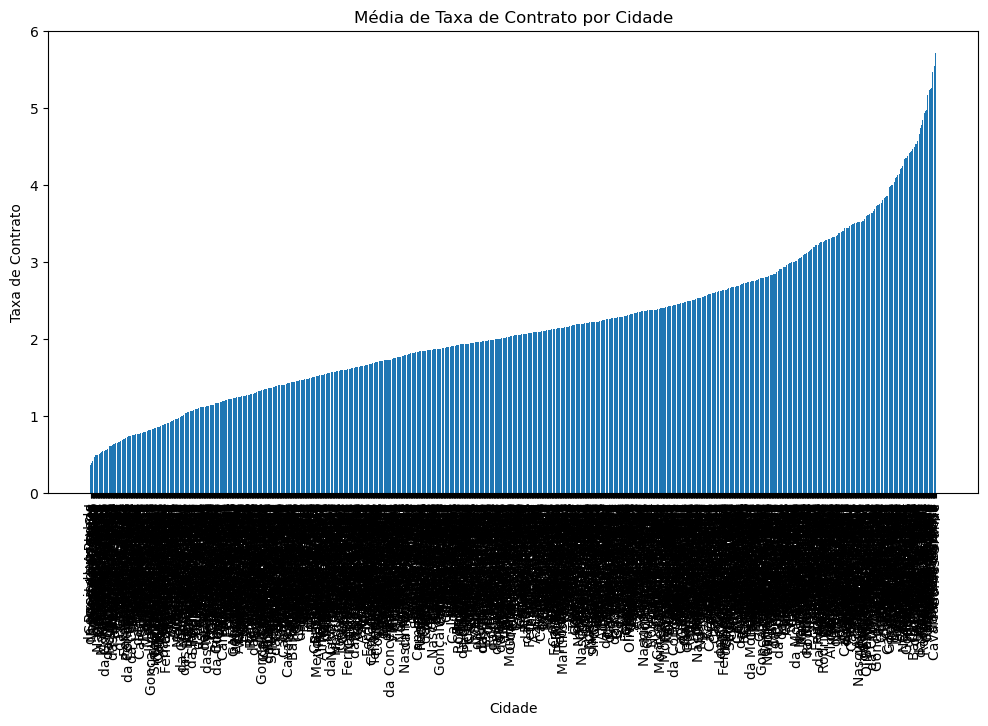

In [ ]:
# Agrupar as taxas de contrato por cidade ou estado e calcular a média
taxas_localidade = df.groupby("cidade")["taxa_contrato"].mean()

# Ordenar as localidades pela taxa de contrato média em ordem crescente
taxas_localidade_sorted = taxas_localidade.sort_values()

# Configurar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(taxas_localidade_sorted.index, taxas_localidade_sorted.values)
plt.title("Média de Taxa de Contrato por Cidade")
plt.xlabel("Cidade")
plt.ylabel("Taxa de Contrato")

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()

In [ ]:
df_taxas_localidade = pd.DataFrame({"Localidade": taxas_localidade_sorted.index, "Taxa de Contrato Média": taxas_localidade_sorted.values})
print(df_taxas_localidade)

                 Localidade  Taxa de Contrato Média
0        da Rosa de Azevedo                    0.36
1        Correia das Pedras                    0.38
2             da Luz do Sul                    0.39
3          Costa das Flores                    0.42
4        Novaes de Monteiro                    0.44
...                     ...                     ...
1351        da Paz de Rocha                    5.51
1352        Moraes da Serra                    5.51
1353       da Cruz do Campo                    5.55
1354  Cavalcanti de Barbosa                    5.68
1355           Gomes Grande                    5.72

[1356 rows x 2 columns]


## 2.4. A taxa de contrato varia de acordo com o estado dos clientes.

**Correto:** A taxa de algumas varia de acordo com o estado

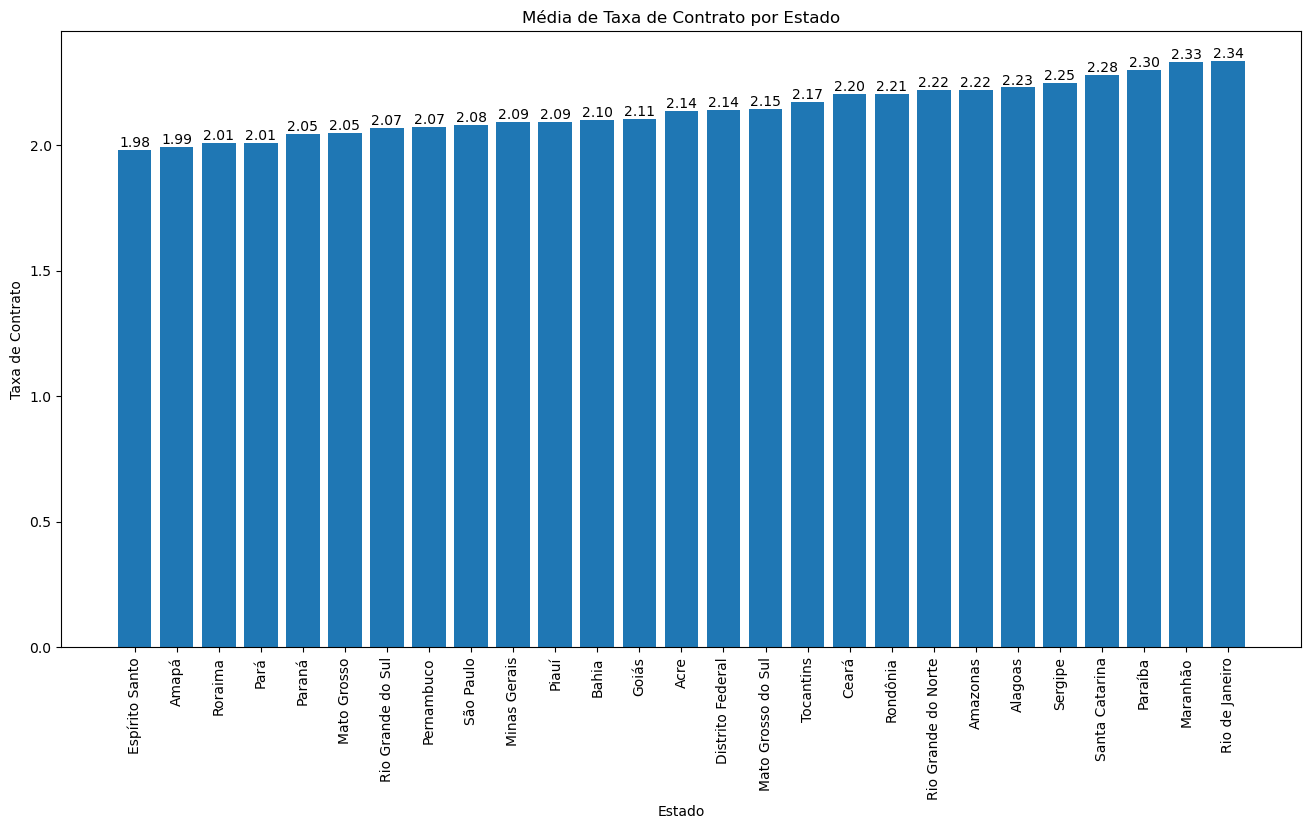

In [ ]:
# Agrupar as taxas de contrato por estado e calcular a média
taxas_localidade = df.groupby("estado")["taxa_contrato"].mean()

# Ordenar as localidades pela taxa de contrato média em ordem crescente
taxas_localidade_sorted = taxas_localidade.sort_values()

# Configurar o gráfico de barras
plt.figure(figsize=(16, 8))
plt.bar(taxas_localidade_sorted.index, taxas_localidade_sorted.values)
plt.title("Média de Taxa de Contrato por Estado")
plt.xlabel("Estado")
plt.ylabel("Taxa de Contrato")

# Adicionar rótulos aos dados do gráfico
for i, v in enumerate(taxas_localidade_sorted.values):
    plt.text(i, v, "{:.2f}".format(v), ha="center", va="bottom")

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=90)

# Exibir o gráfico
plt.show()

## 2.5. <s>Existem diferenças nas taxas de contrato entre os gêneros dos clientes.</s>

**Errado:** A taxa de contrato não tem diferença relacionado ao gênero dos clientes.

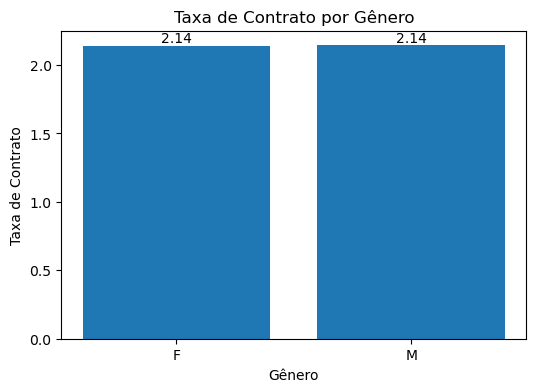

In [ ]:
# Calcular a média das taxas de contrato por gênero
taxas_genero = df.groupby("genero")["taxa_contrato"].mean()

# Configurar o gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(taxas_genero.index, taxas_genero.values)
plt.title("Taxa de Contrato por Gênero")
plt.xlabel("Gênero")
plt.ylabel("Taxa de Contrato")

# Adicionar rótulos aos dados do gráfico
for i, v in enumerate(taxas_genero.values):
    plt.text(i, v, "{:.2f}".format(v), ha="center", va="bottom")

# Exibir o gráfico
plt.show()

## 2.6. A taxa de contrato varia de acordo com o tipo de operação realizada.

**Correto:** A taxa varia um pouco com relação ao tipo de contrato.

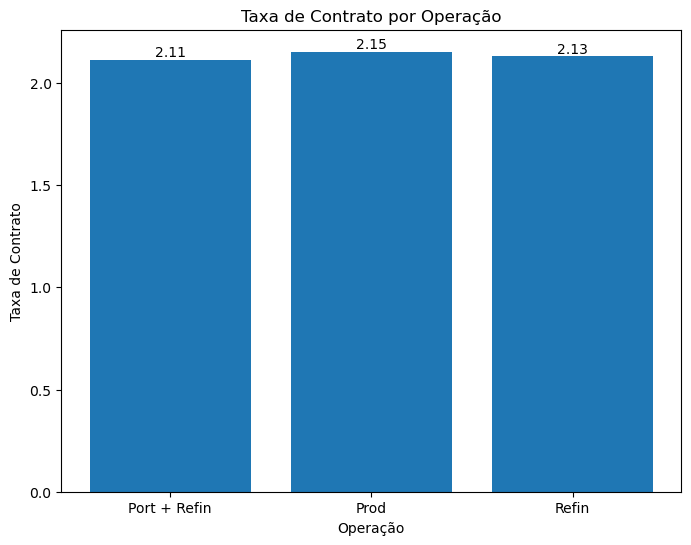

In [ ]:
# Calcular a média das taxas de contrato por operação
taxas_operacao = df.groupby("operacao")["taxa_contrato"].mean()

# Configurar o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(taxas_operacao.index, taxas_operacao.values)
plt.title("Taxa de Contrato por Operação")
plt.xlabel("Operação")
plt.ylabel("Taxa de Contrato")

# Adicionar rótulos aos dados do gráfico
for i, v in enumerate(taxas_operacao.values):
    plt.text(i, v, "{:.2f}".format(v), ha="center", va="bottom")

# Exibir o gráfico
plt.show()

## 2.7. A taxa de contrato está relacionada ao valor principal da operação

**Correto:** A taxa de contrato varia de acordo com o valor principal.

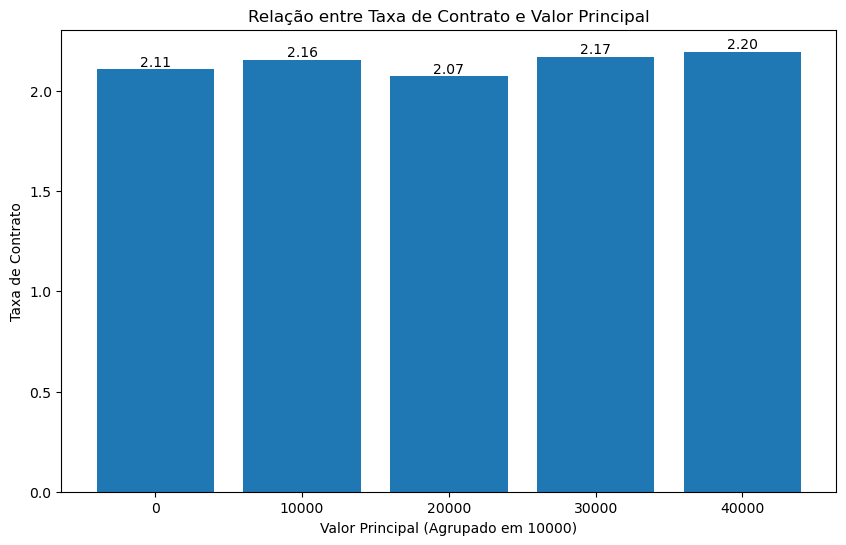

In [ ]:
# Agrupar as taxas de contrato pelo valor principal da operação e calcular a média
taxas_valor_principal = df.groupby(np.floor_divide(df["valor_principal"], 10000)*10000)["taxa_contrato"].mean()

# Filtrar os valores até 100000
taxas_valor_principal = taxas_valor_principal[taxas_valor_principal.index <= 100000]

# Configurar o gráfico de barras com distribuição de valores
plt.figure(figsize=(10, 6))
plt.bar(taxas_valor_principal.index, taxas_valor_principal.values, width=8000)
plt.title("Relação entre Taxa de Contrato e Valor Principal")
plt.xlabel("Valor Principal (Agrupado em 10000)")
plt.ylabel("Taxa de Contrato")

# Adicionar rótulos aos dados do gráfico
for x, y in zip(taxas_valor_principal.index, taxas_valor_principal.values):
    plt.text(x, y, "{:.2f}".format(y), ha="center", va="bottom")

# Exibir o gráfico
plt.show()

## 2.8. A taxa varia de acordo com o número de parcelas

**Correto:** A taxa tende a ser maior de acorod com o número de parcelas. A de 80, pode ser que ficou um pouco menor por conta do valor de entrada ser um pouco maior.

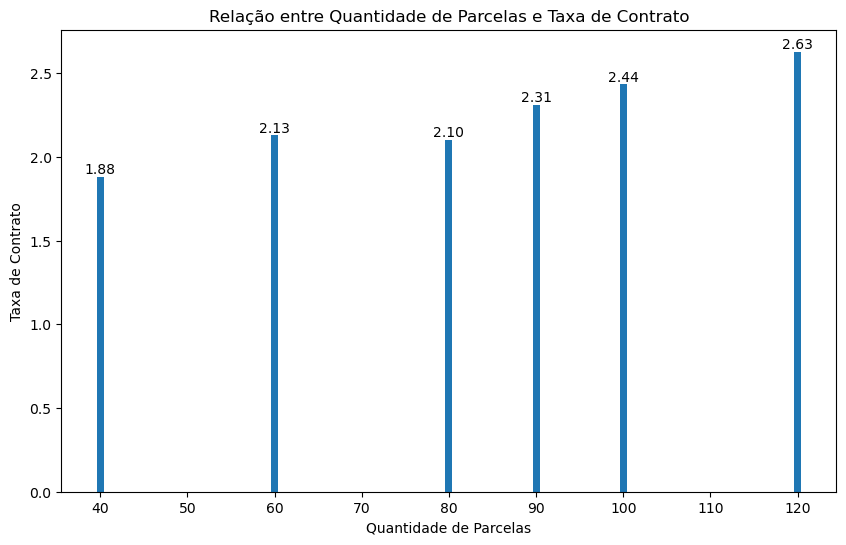

In [ ]:
# Calcular a média da taxa de contrato por quantidade de parcelas
media_taxa_parcelas = df.groupby("parcelas")["taxa_contrato"].mean()

# Configurar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(media_taxa_parcelas.index, media_taxa_parcelas.values)
plt.title("Relação entre Quantidade de Parcelas e Taxa de Contrato")
plt.xlabel("Quantidade de Parcelas")
plt.ylabel("Taxa de Contrato")

# Adicionar rótulos aos dados do gráfico com deslocamento vertical
for x, y in zip(media_taxa_parcelas.index, media_taxa_parcelas.values):
    plt.text(x, y, "{:.2f}".format(y), ha="center", va="bottom")

# Exibir o gráfico
plt.show()

## 2.9. <s>Quanto maior o valor da parcela, menor a taxa de contrato.</s>

**Errado:** Os valores maiores de parcela, tem uma taxa de contrato maior

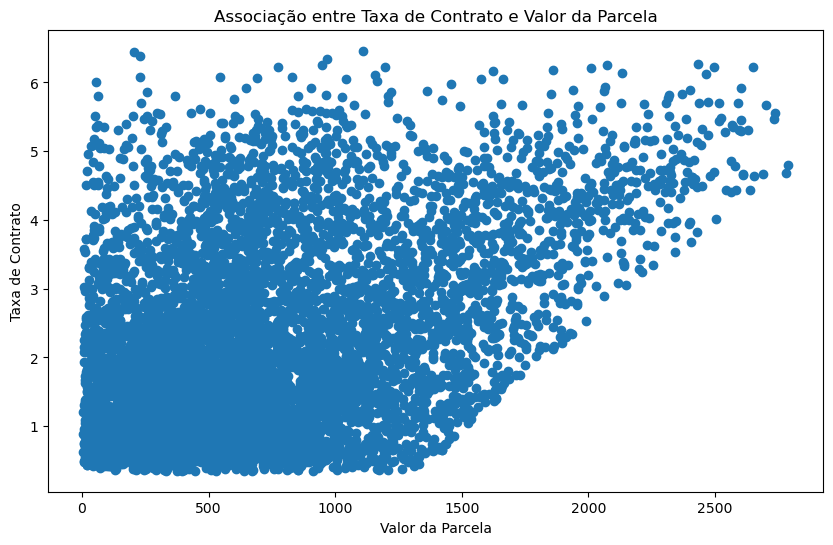

In [ ]:
# Calcular a média da taxa de contrato por valor da parcela
media_taxa_parcela = df.groupby("valor_parcela")["taxa_contrato"].mean()

# Configurar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(media_taxa_parcela.index, media_taxa_parcela.values)
plt.title("Associação entre Taxa de Contrato e Valor da Parcela")
plt.xlabel("Valor da Parcela")
plt.ylabel("Taxa de Contrato")

# Exibir o gráfico
plt.show()

## 2.10. A taxa de contrato está relacionada ao valor bruto da operação.

**Correto:** Podemos perceber que as operações com valores maiores, tem uma taxa mais elevada.

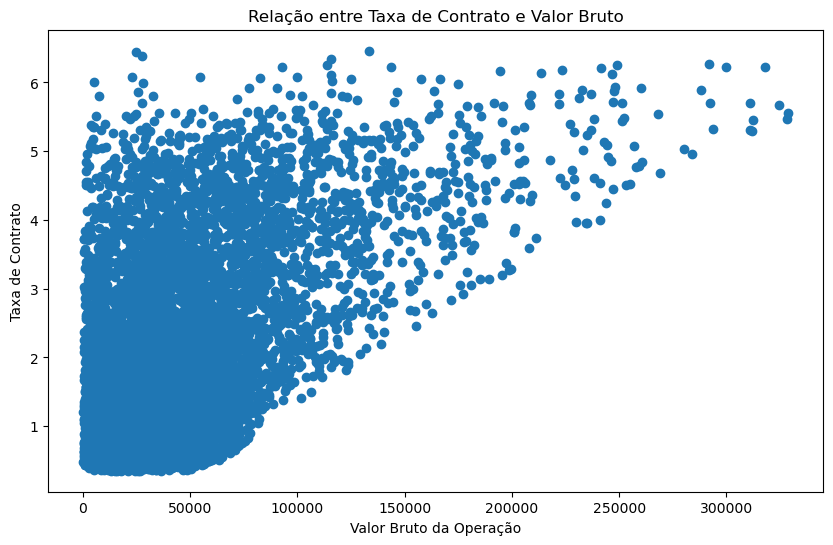

In [ ]:
# Relacionar a taxa de contrato com o valor bruto da operação
plt.figure(figsize=(10, 6))
plt.scatter(df["valor_bruto"], df["taxa_contrato"])
plt.title("Relação entre Taxa de Contrato e Valor Bruto")
plt.xlabel("Valor Bruto da Operação")
plt.ylabel("Taxa de Contrato")

# Exibir o gráfico
plt.show()

## 2.11. A taxa de contrato está relacionada ao número de contratos.

**Correto:** Clientes com mais contratos tem uma taxa menor

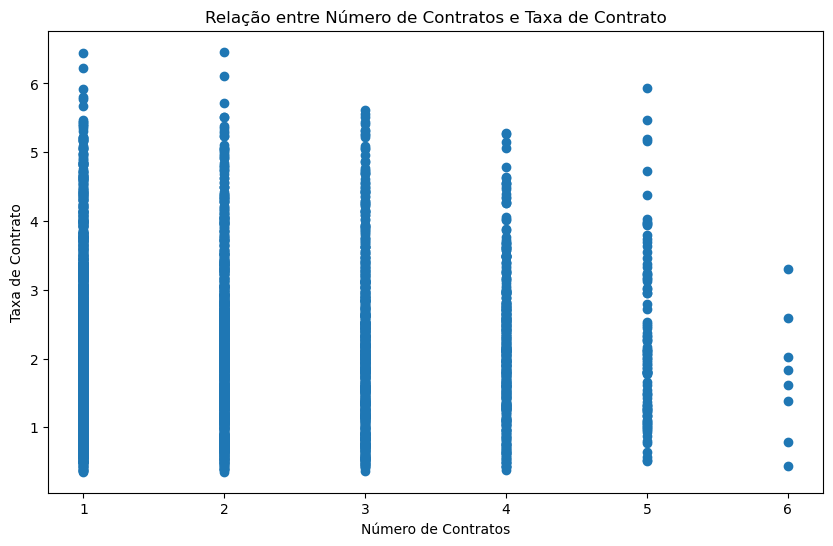

In [ ]:
# Agrupar os contratos por ID e calcular a média da taxa
media_taxa_contratos = df.groupby("id")["taxa_contrato"].mean()

# Contar a quantidade de contratos por ID
quantidade_contratos = df["id"].value_counts()

# Criar o gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(quantidade_contratos, media_taxa_contratos)
plt.title("Relação entre Número de Contratos e Taxa de Contrato")
plt.xlabel("Número de Contratos")
plt.ylabel("Taxa de Contrato")

# Exibir o gráfico
plt.show()

# 3.0. Preparação dos Dados

In [ ]:
df1 = df.copy()

In [ ]:
df1.dtypes

id                         object
contrato                    int64
data_operacao              object
nascimento         datetime64[ns]
idade                       int64
genero                     object
bairro                     object
cidade                     object
estado                     object
cep                        object
telefone                   object
cartao                     object
email                      object
ocupacao                   object
empregador                 object
operacao                   object
valor_principal           float64
parcelas                    int64
parcelas_pagas              int64
taxa_contrato             float64
valor_parcela             float64
valor_bruto               float64
faixa_etaria             category
dtype: object

## 3.1. Encoding

In [ ]:
#genero
gen_dic ={"F":1, "M":2}
df1["genero"]= df1["genero"].replace(gen_dic)

#operação
opr_dic ={"Prod":1, "Refin":2, "Port + Refin":3}
df1["operacao"]= df1["operacao"].replace(opr_dic)

#estados
est_dic = {
    "Acre": 1,
    "São Paulo": 2,
    "Rio de Janeiro": 3,
    "Ceará": 4,
    "Rondônia": 5,
    "Pernambuco": 6,
    "Pará": 7,
    "Alagoas": 8,
    "Rio Grande do Sul": 9,
    "Bahia": 10,
    "Piauí": 11,
    "Paraíba": 12,
    "Espírito Santo": 13,
    "Amapá": 14,
    "Sergipe": 15,
    "Paraná": 16,
    "Goiás": 17,
    "Roraima": 18,
    "Minas Gerais": 19,
    "Rio Grande do Norte": 20,
    "Mato Grosso": 21,
    "Tocantins": 22,
    "Mato Grosso do Sul": 23,
    "Amazonas": 24,
    "Santa Catarina": 25,
    "Distrito Federal": 26,
    "Maranhão": 27}
df1["estado"]= df1["estado"].replace(est_dic)

# id - Label Encoding
le = LabelEncoder()
df1["id"] = le.fit_transform(df1["id"])

In [ ]:
df1.head()

,id,contrato,data_operacao,nascimento,idade,genero,bairro,cidade,estado,cep,telefone,cartao,email,ocupacao,empregador,operacao,valor_principal,parcelas,parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto,faixa_etaria
0,1558,1760865030954,2019-09-13,1974-06-08,49,1,Conjunto Paulo Vi,Moreira,3,XXXXX-685,XXXXXXXXXXXXX2797,XXXX.XXXX.XXXX.XXXX,XXXXa51@mXXXXXXXXXXXX,Espeleologista,e53d5342e82e0ce6061bc3aaea1a986f24a73613,1,27810.69,100,20,1.46,531.56,53156.00,40-50
1,1052,6023030871505,2022-11-03,1988-07-23,34,1,Minas Caixa,da Mota de Azevedo,14,XXXXX735,XXXXX-XXXX,XXXXXXXXXX562960,XXXXXXXXXXXnda@tXXXXXXXXXXXX,Mágico,f715ffaf2c8294df43df3357c6a37f04b900fb06,2,9589.96,40,6,4.54,523.82,20952.80,30-40
4,1334,3823566005671,2022-11-16,1985-07-14,38,1,Conjunto Floramar,Moreira de Goiás,21,XXXXX384,XXXXXXXXXXXXX7089,XXXX.XXXX.XXXX.XXXX,xxx@xxxxx.com,Treinador,f97b240dc24290c19e717d7a654747aa31722ad3,1,31186.17,100,10,3.28,1066.11,106611.00,30-40
5,1407,5444678845030,2020-11-02,1984-05-29,39,2,Vila Fumec,Campos,18,XXXXX-XXX,XXXXXXXXXXXXX91 1070,XXXXXXXXXX12230,xxx@xxxxx.com,Cirurgião bucal,autônomo,3,41432.39,40,8,0.71,1193.00,47720.00,30-40
7,2623,4167168660296,2021-12-08,1997-10-18,25,1,Vila Da Ária,Araújo,8,XXXXX007,XXXXXXXXXXXXX4284,XXXX.XXXX.XXXX.XXXX,XXXXXXXXXXXXXara@aXXXXXXXXXXXX,Velejador,8e9e183c401487c93eb9c9127d15e0908208d252,2,2832.39,80,12,2.67,86.12,6889.60,<30


# 4.0. Seleção das Variáveis

In [ ]:
df2 = df1.copy()

In [ ]:
df2 = df2.drop(["faixa_etaria", "bairro", "nascimento", "cidade", "cep", "telefone", "cartao", "email", "ocupacao", "empregador"], axis=1)

In [ ]:
df2.head()

,id,contrato,data_operacao,idade,genero,estado,operacao,valor_principal,parcelas,parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,1558,1760865030954,2019-09-13,49,1,3,1,27810.69,100,20,1.46,531.56,53156.00
1,1052,6023030871505,2022-11-03,34,1,14,2,9589.96,40,6,4.54,523.82,20952.80
4,1334,3823566005671,2022-11-16,38,1,21,1,31186.17,100,10,3.28,1066.11,106611.00
5,1407,5444678845030,2020-11-02,39,2,18,3,41432.39,40,8,0.71,1193.00,47720.00
7,2623,4167168660296,2021-12-08,25,1,8,2,2832.39,80,12,2.67,86.12,6889.60


## 4.1. Separando os dados de treino e teste

### Vou utilizar os dados dos ultimos semanas para o teste pois são mais próximas da data atual e devem refletir melhor a realidade

In [ ]:
# Converter a coluna "data_operacao" para o tipo "datetime"
df2["data_operacao"] = pd.to_datetime(df2["data_operacao"])

In [ ]:
# Calcular a maior e a menor data_operacao
maior_data = df2["data_operacao"].max()
menor_data = df2["data_operacao"].min()

print("Maior data:", maior_data)
print("Menor data:", menor_data)

Maior data: 2022-12-30 00:00:00
Menor data: 2019-01-01 00:00:00


In [ ]:
#pegar 6 ultimas semanas
data_teste_ini = maior_data - dt.timedelta(weeks=6)
print("Data das últimas 6 semanas:", data_teste_ini)

Data das últimas 6 semanas: 2022-11-18 00:00:00


In [ ]:
# Calcular a data para os próximos 2 anos
data_prev = maior_data + dt.timedelta(days=365*2)
print("Data para os próximos 2 anos:", data_prev)

Data para os próximos 2 anos: 2024-12-29 00:00:00


In [ ]:
#Dinâmica:
# X = dataset todo
# Y = var resposta

# Dados de treino
X_train = df2[df2['data_operacao'] < '2022-11-18']
y_train = X_train['valor_principal']

# Dados de teste - últimas 6 semanas
X_test = df2[df2['data_operacao'] >= '2022-11-18']
y_test = X_test['valor_principal']

# Conferência das datas
print("Menor Data Treino:", X_train['data_operacao'].min())
print("Maior Data Treino:", X_train['data_operacao'].max())

print("\nMenor Data Teste:", X_test['data_operacao'].min())
print("Maior Data Teste:", X_test['data_operacao'].max())

Menor Data Treino: 2019-01-01 00:00:00
Maior Data Treino: 2022-11-17 00:00:00

Menor Data Teste: 2022-11-18 00:00:00
Maior Data Teste: 2022-12-30 00:00:00


In [ ]:
X_train.head()

,id,contrato,data_operacao,idade,genero,estado,operacao,valor_principal,parcelas,parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,1558,1760865030954,2019-09-13,49,1,3,1,27810.69,100,20,1.46,531.56,53156.00
1,1052,6023030871505,2022-11-03,34,1,14,2,9589.96,40,6,4.54,523.82,20952.80
4,1334,3823566005671,2022-11-16,38,1,21,1,31186.17,100,10,3.28,1066.11,106611.00
5,1407,5444678845030,2020-11-02,39,2,18,3,41432.39,40,8,0.71,1193.00,47720.00
7,2623,4167168660296,2021-12-08,25,1,8,2,2832.39,80,12,2.67,86.12,6889.60


In [ ]:
X_train.shape

(7325, 13)

In [ ]:
X_test.head()

,id,contrato,data_operacao,idade,genero,estado,operacao,valor_principal,parcelas,parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
86,348,4047730367016,2022-12-04,36,1,23,2,9329.44,80,4,3.58,355.67,28453.60
131,712,9654012766051,2022-12-22,36,1,19,3,9079.55,100,90,5.55,506.30,50630.00
162,2471,2550927483052,2022-12-18,23,1,8,1,37192.50,90,18,3.66,1417.79,127601.10
196,1158,7686590083949,2022-12-29,24,1,9,1,16632.85,60,9,2.78,573.16,34389.60
227,389,3513717874453,2022-12-27,22,1,22,1,19710.36,60,6,3.40,774.17,46450.20


## 4.2.Randon Forest para seleção de features

In [ ]:
#para X_train, remover "data_operacao", usado para controle dos splits, e valor_principal, sendo a var resposta, logo não deve estar em X
X_train = X_train.drop( ["data_operacao", "valor_principal"],axis=1 )
X_test = X_test.drop( ["data_operacao", "valor_principal"],axis=1 )

In [ ]:
X_train.head(3)

,id,contrato,idade,genero,estado,operacao,parcelas,parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
0,1558,1760865030954,49,1,3,1,100,20,1.46,531.56,53156.00
1,1052,6023030871505,34,1,14,2,40,6,4.54,523.82,20952.80
4,1334,3823566005671,38,1,21,1,100,10,3.28,1066.11,106611.00


In [ ]:
X_train.shape

(7325, 11)

In [ ]:
X_test.head(3)

,id,contrato,idade,genero,estado,operacao,parcelas,parcelas_pagas,taxa_contrato,valor_parcela,valor_bruto
86,348,4047730367016,36,1,23,2,80,4,3.58,355.67,28453.60
131,712,9654012766051,36,1,19,3,100,90,5.55,506.30,50630.00
162,2471,2550927483052,23,1,8,1,90,18,3.66,1417.79,127601.10


In [ ]:
X_test.shape

(310, 11)

In [ ]:
# Criar modelo de árvore de feature selection que seleciona as categorias com base na mediana da importância
select = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")

# Treinar e utilizar o modelo
select.fit(X_train, y_train)
X_train_rf = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_rf.shape: {}".format(X_train_rf.shape))

X_train.shape: (259, 11)
X_train_rf.shape: (259, 6)


[ True  True  True False False False False False  True  True  True]


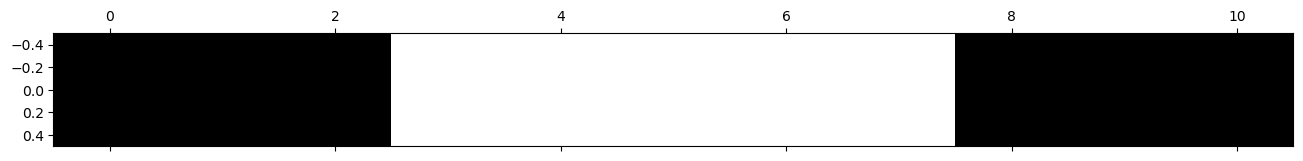

In [ ]:
#método para identificar as features selecionadas
mask_rf = select.get_support()
print(mask_rf)
# visualizar the mask -- preto é verdadeiro e branco é falso
plt.matshow(mask_rf.reshape(1, -1), cmap="gray_r");

In [ ]:
# Verificar quais são as categorias selecionadas:
cat_rf = X_train.loc[:, [True, True, True, False, False, False, False, False, True, True, True]].columns
cat_rf

Index(['id', 'contrato', 'idade', 'taxa_contrato', 'valor_parcela',
       'valor_bruto'],
      dtype='object')

## 4.3. Seleção de variáveis customizada

In [ ]:
cat_rf = ["id", "contrato", "idade", "taxa_contrato", "parcelas", "parcelas_pagas", "valor_parcela",
                  "valor_bruto"]

In [ ]:
#adicionando as colunas
cat_add = ["data_operacao", "valor_principal"]

caracteristicas = cat_rf.copy()
caracteristicas.extend(cat_add)

In [ ]:
X = df2[caracteristicas]
y = df2['valor_principal']  #valor a ser previsto

In [ ]:
X

,id,contrato,idade,taxa_contrato,parcelas,parcelas_pagas,valor_parcela,valor_bruto,data_operacao,valor_principal
0,1558,1760865030954,49,1.46,100,20,531.56,53156.00,2019-09-13,27810.69
1,1052,6023030871505,34,4.54,40,6,523.82,20952.80,2022-11-03,9589.96
4,1334,3823566005671,38,3.28,100,10,1066.11,106611.00,2022-11-16,31186.17
5,1407,5444678845030,39,0.71,40,8,1193.00,47720.00,2020-11-02,41432.39
7,2623,4167168660296,25,2.67,80,12,86.12,6889.60,2021-12-08,2832.39
...,...,...,...,...,...,...,...,...,...,...
14886,3669,2376263311671,23,1.11,80,44,211.16,16892.80,2021-06-15,11175.01
14887,3669,9874830035652,23,4.44,40,6,2637.49,105499.60,2022-12-10,48938.95
14888,1683,2425936612604,28,1.02,40,6,404.19,16167.60,2021-03-29,13231.81
14890,1683,5458053922742,28,2.81,60,54,585.22,35113.20,2021-11-24,16879.13


In [ ]:
y

0       27810.69
1        9589.96
4       31186.17
5       41432.39
7        2832.39
          ...   
14886   11175.01
14887   48938.95
14888   13231.81
14890   16879.13
14891    8223.88
Name: valor_principal, Length: 7635, dtype: float64

# 5.0. Modelos de Machine Learning

## 5.1. Regressão Linear

In [ ]:
# Construir o modelo de regressão linear
model = LinearRegression()

# Treinar o modelo usando os dados de treinamento
model.fit(X_train, y_train)

# Fazer previsões usando os dados de treinamento
y_pred_train = model.predict(X_train)

# Calcular o MAE (Mean Absolute Error) para os dados de treinamento
mae_train = mean_absolute_error(y_train, y_pred_train)
print('MAE (Treinamento):', mae_train)

# Calcular o MAPE (Mean Absolute Percentage Error) para os dados de treinamento
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print('MAPE (Treinamento):', mape_train)

# Fazer previsões usando os dados completos
y_pred = model.predict(X_test)

# Calcular o MAE (Mean Absolute Error) para todos os dados
mae = mean_absolute_error(y_test, y_pred)
print('MAE (Teste):', mae)

# Calcular o MAPE (Mean Absolute Percentage Error) para todos os dados
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAPE (Teste):', mape)

# Calcular o RMSE (Root Mean Squared Error) para todos os dados
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE (Teste):', rmse)

MAE (Treinamento): 1793.1434262048333
MAPE (Treinamento): 0.23731545408020385
MAE (Teste): 1736.3313366198424
MAPE (Teste): 0.22406813402855605
RMSE (Teste): 2274.332843753788


## 5.2. ARIMA

In [ ]:
# Construir o modelo ARIMA
model = ARIMA(y_train, order=(1, 0, 0))  # Configurar a ordem do modelo ARIMA (p, d, q)

# Treinar o modelo usando os dados de treinamento
model_fit = model.fit()

# Fazer previsões usando os dados de treinamento
y_pred_train = model_fit.predict()

# Calcular o MAE (Mean Absolute Error) para os dados de treinamento
mae_train = mean_absolute_error(y_train, y_pred_train)
print('MAE (Treinamento):', mae_train)

# Calcular o MAPE (Mean Absolute Percentage Error) para os dados de treinamento
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print('MAPE (Treinamento):', mape_train)

# Fazer previsões usando os dados de teste
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Calcular o MAE (Mean Absolute Error) para os dados de teste
mae = mean_absolute_error(y_test, y_pred)
print('MAE (Teste):', mae)

# Calcular o MAPE (Mean Absolute Percentage Error) para os dados de teste
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAPE (Teste):', mape)

# Calcular o RMSE (Root Mean Squared Error) para os dados de teste
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE (Teste):', rmse)

MAE (Treinamento): 12063.643311454105
MAPE (Treinamento): 1.8630098508937993
MAE (Teste): 11991.574446500315
MAPE (Teste): 1.8800486766638425
RMSE (Teste): 13848.385360197959


## 5.3. Cross Validation

In [ ]:
# Função para calcular as métricas de avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, mape, rmse

# Número de folds para a validação cruzada
n_splits = 5

# Instanciar o objeto TimeSeriesSplit para dividir os dados em folds
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listas para armazenar as métricas de avaliação de cada fold
mae_arima = []
mape_arima = []
rmse_arima = []

# Realizar a validação cruzada manualmente
for train_index, test_index in tscv.split(X_test):
    # Separar os dados de treinamento e teste para o fold atual
    X_train, X_val = X_test.iloc[train_index], X_test.iloc[test_index]
    y_train, y_val = y_test.iloc[train_index], y_test.iloc[test_index]

    # Criar e ajustar o modelo ARIMA para o fold atual
    model_arima = ARIMA(y_train, order=(1, 0, 0))
    model_fit = model_arima.fit()

    # Fazer previsões para o fold de validação
    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_val) - 1)

    # Calcular as métricas de avaliação para o fold atual
    fold_mae, fold_mape, fold_rmse = calculate_metrics(y_val, y_pred)
    mae_arima.append(fold_mae)
    mape_arima.append(fold_mape)
    rmse_arima.append(fold_rmse)

# Calcular as médias das métricas de avaliação para todos os folds
mean_mae_arima = np.mean(mae_arima)
mean_mape_arima = np.mean(mape_arima)
mean_rmse_arima = np.mean(rmse_arima)

# Imprimir as médias das métricas
print("ARIMA:")
print("MAE: ", mean_mae_arima)
print("MAPE: ", mean_mape_arima)
print("RMSE: ", mean_rmse_arima)

ARIMA:
MAE:  12082.813970810403
MAPE:  2.028773872654509
RMSE:  13981.76297340462


MAE (Erro Médio Absoluto): É uma medida de quão próximo as previsões estão dos valores reais. (12.082,81)
MAPE (Erro Percentual Médio Absoluto): É uma medida de quão precisas são as previsões em termos percentuais.(2.03%)
RMSE (Raiz do Erro Quadrático Médio): E é uma medida de dispersão das diferenças entre as previsões do modelo e os valores reais. (13.981,76)

# 6.0 Utilizando ARIMA para previsão de 2 anos

In [ ]:
# Construir o modelo ARIMA
modelo = ARIMA(y_train, order=(1, 0, 0))

# Treinar o modelo usando os dados de treinamento
modelo_ajustado = modelo.fit()

# Fazer previsões usando os dados de treinamento
pred_train = modelo_ajustado.predict()

# Calcular o MAE (Erro Médio Absoluto) para os dados de treinamento
mae_train = mean_absolute_error(y_train, pred_train)
print('MAE (Treinamento):', mae_train)

# Calcular o MAPE (Erro Percentual Médio Absoluto) para os dados de treinamento
mape_train = mean_absolute_percentage_error(y_train, pred_train)
print('MAPE (Treinamento):', mape_train)

# Fazer previsões usando os dados de teste
previsao = modelo_ajustado.predict(start=len(y_train), end=len(y_train) + len(y_test) + 730) #2 anos em dias

# Calcular o MAE (Erro Médio Absoluto) para os dados de teste
mae = mean_absolute_error(y_test, previsao[:len(y_test)])
print('MAE (Teste):', mae)

# Calcular o MAPE (Erro Percentual Médio Absoluto) para os dados de teste
mape = mean_absolute_percentage_error(y_test, previsao[:len(y_test)])
print('MAPE (Teste):', mape)

# Calcular o RMSE (Erro Quadrático Médio) para os dados de teste
mse = mean_squared_error(y_test, previsao[:len(y_test)])
rmse = np.sqrt(mse)
print('RMSE (Teste):', rmse)

MAE (Treinamento): 12063.643311454105
MAPE (Treinamento): 1.8630098508937993
MAE (Teste): 11991.574446500315
MAPE (Teste): 1.8800486766638425
RMSE (Teste): 13848.385360197959


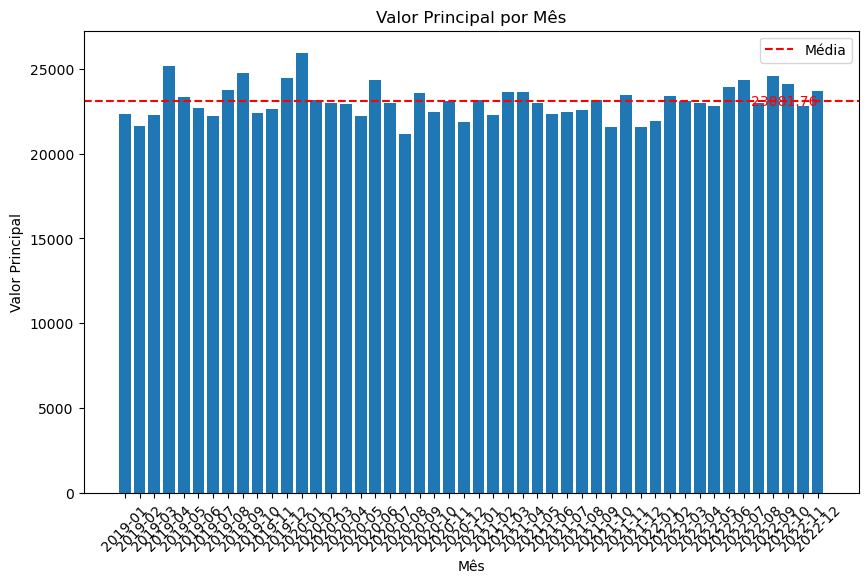

In [ ]:
# Converter a coluna "data_operacao" para o tipo datetime
df2["data_operacao"] = pd.to_datetime(df2["data_operacao"])

# Agrupar os valores principais por mês e calcular a média
valores_mes = df2.groupby(df["data_operacao"].dt.to_period("M"))["valor_principal"].mean()

# Configurar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(valores_mes.index.astype(str), valores_mes.values)
plt.axhline(y=valores_mes.mean(), color='red', linestyle='--', label='Média')
plt.title("Valor Principal por Mês")
plt.xlabel("Mês")
plt.ylabel("Valor Principal")

# Rotacionar os rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Adicionar rótulos aos dados da linha média
plt.text(len(valores_mes) - 1, valores_mes.mean(), "{:.2f}".format(valores_mes.mean()), ha='right', va='center', color='red')

# Exibir o gráfico
plt.legend()
plt.show()

In [ ]:
# Salvar o modelo ARIMA
modelo_ajustado.save("arima_model.pkl")

# Fazer previsões para 2 anos
previsao_2_anos = modelo_ajustado.predict(start=len(y_train), end=len(y_train) + 730) # 2 anos em dias

# Calcular as métricas de avaliação para os dados de teste
mae_2_anos = mean_absolute_error(y_test, previsao_2_anos[:len(y_test)])
mape_2_anos = mean_absolute_percentage_error(y_test, previsao_2_anos[:len(y_test)])
rmse_2_anos = np.sqrt(mean_squared_error(y_test, previsao_2_anos[:len(y_test)]))

# Imprimir as métricas de avaliação para os dados de teste
print("Métricas de Avaliação para 2 Anos:")
print("MAE:", mae_2_anos)
print("MAPE:", mape_2_anos)
print("RMSE:", rmse_2_anos)

Métricas de Avaliação para 2 Anos:
MAE: 11991.574446500315
MAPE: 1.8800486766638425
RMSE: 13848.385360197959


MAE: A cada predição para 2 anos, eu erro em média ± R$11.991,57 por dia
MAPE: A cada predição para 2 anos, eu erro em média ± 18,8% por dia
RMSE:A cada predição para 2 anos, eu erro em média ± R$13.848,38 por dia